In [65]:
from neural_network import NeuralNetwork
from data import Instance, DataSet
from miscellaneous import initialize_data, plot_graph, plot_points
from activation_function import *
import matplotlib.pyplot as plt
import pandas as pd
import copy
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings('ignore')

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Carregando dados e Ajustando labels

In [67]:
# Carregando dados
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
test = test.sample(430, replace = False, random_state = 11403723)

# Ajustando nomes
train_labels = [i.lower() for i in train.columns.values]
test_labels = [i.lower() for i in test.columns.values]

rename_dict_train = { i: j for i,j in zip(train.columns.values, train_labels) }
rename_dict_test = { i: j for i,j in zip(test.columns.values, test_labels) }

train.rename(columns = rename_dict_train, inplace = True)
test.rename(columns = rename_dict_test, inplace = True)

#### Selecionando atributos relevantes

In [68]:
train = train.filter(['pclass', 'sex', 'age', 'fare', 'cabin', 'embarked', 'survived'], axis = 1)
test = test.filter(['pclass', 'sex', 'age', 'fare', 'cabin', 'embarked', 'survived'], axis = 1)
display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,male,22.0,7.2500,NaN,S,0
1,1,female,38.0,71.2833,C85,C,1
2,3,female,26.0,7.9250,NaN,S,1
3,1,female,35.0,53.1000,C123,S,1
4,3,male,35.0,8.0500,NaN,S,0
5,3,male,NaN,8.4583,NaN,Q,0
6,1,male,54.0,51.8625,E46,S,0
7,3,male,2.0,21.0750,NaN,S,0
8,3,female,27.0,11.1333,NaN,S,1
9,2,female,14.0,30.0708,NaN,C,1


##### Fare e Age - Completando valores ausentes

In [69]:
#train['age'].fillna(train['age'].median(), inplace = True)
#test['age'].fillna(test['age'].median(), inplace = True)

train.dropna(subset = ['age'], inplace = True)
test.dropna(subset = ['age'], inplace = True)

train['fare'].fillna(train['fare'].median(), inplace = True)
test['fare'].fillna(test['fare'].median(), inplace = True)

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,male,22.0,7.2500,NaN,S,0
1,1,female,38.0,71.2833,C85,C,1
2,3,female,26.0,7.9250,NaN,S,1
3,1,female,35.0,53.1000,C123,S,1
4,3,male,35.0,8.0500,NaN,S,0
6,1,male,54.0,51.8625,E46,S,0
7,3,male,2.0,21.0750,NaN,S,0
8,3,female,27.0,11.1333,NaN,S,1
9,2,female,14.0,30.0708,NaN,C,1
10,3,female,4.0,16.7000,G6,S,1


##### Sex - Transformando em atributo numérico

In [70]:
binarizer = LabelBinarizer()
train['sex'] = binarizer.fit_transform(train['sex'])
test['sex'] = binarizer.fit_transform(test['sex'])

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,NaN,S,0
1,1,0,38.0,71.2833,C85,C,1
2,3,0,26.0,7.9250,NaN,S,1
3,1,0,35.0,53.1000,C123,S,1
4,3,1,35.0,8.0500,NaN,S,0
6,1,1,54.0,51.8625,E46,S,0
7,3,1,2.0,21.0750,NaN,S,0
8,3,0,27.0,11.1333,NaN,S,1
9,2,0,14.0,30.0708,NaN,C,1
10,3,0,4.0,16.7000,G6,S,1


##### Embarked - Completando valores ausentes e Transformando em atributo numérico

In [71]:
train['embarked'].fillna(str(train['embarked'].mode()), inplace = True)
test['embarked'].fillna(str(test['embarked'].mode()), inplace = True)

encoder = LabelEncoder()
train['embarked'] = encoder.fit_transform(train['embarked'])
test['embarked'] = encoder.fit_transform(test['embarked'])

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,NaN,3,0
1,1,0,38.0,71.2833,C85,1,1
2,3,0,26.0,7.9250,NaN,3,1
3,1,0,35.0,53.1000,C123,3,1
4,3,1,35.0,8.0500,NaN,3,0
6,1,1,54.0,51.8625,E46,3,0
7,3,1,2.0,21.0750,NaN,3,0
8,3,0,27.0,11.1333,NaN,3,1
9,2,0,14.0,30.0708,NaN,1,1
10,3,0,4.0,16.7000,G6,3,1


##### Cabin - Transformando em atributo numérico

In [72]:
train.loc[train['cabin'].notnull(), 'cabin'] = train['cabin'].str[0]
test.loc[test['cabin'].notnull(), 'cabin'] = test['cabin'].str[0]

train['cabin'].fillna('H', inplace = True)
test['cabin'].fillna('H', inplace = True)

train['cabin'] = encoder.fit_transform(train['cabin'])
test['cabin'] = encoder.fit_transform(test['cabin'])

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,7,3,0
1,1,0,38.0,71.2833,2,1,1
2,3,0,26.0,7.9250,7,3,1
3,1,0,35.0,53.1000,2,3,1
4,3,1,35.0,8.0500,7,3,0
6,1,1,54.0,51.8625,4,3,0
7,3,1,2.0,21.0750,7,3,0
8,3,0,27.0,11.1333,7,3,1
9,2,0,14.0,30.0708,7,1,1
10,3,0,4.0,16.7000,6,3,1


##### Remoção de Outliers

In [73]:
for c1, c2 in zip(train, test):
    train = train[~(np.abs(train[c1]-train[c1].mean())>(3*train[c1].std()))]
    test = test[~(np.abs(test[c2]-test[c2].mean())>(3*test[c2].std()))]
    
display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,7,3,0
1,1,0,38.0,71.2833,2,1,1
2,3,0,26.0,7.9250,7,3,1
3,1,0,35.0,53.1000,2,3,1
4,3,1,35.0,8.0500,7,3,0
6,1,1,54.0,51.8625,4,3,0
7,3,1,2.0,21.0750,7,3,0
8,3,0,27.0,11.1333,7,3,1
9,2,0,14.0,30.0708,7,1,1
10,3,0,4.0,16.7000,6,3,1


##### Balanceamento

In [74]:
min_value = min(train['survived'].value_counts())
train = pd.concat([train.query('survived == 1').sample(min_value, replace = True, random_state = 11403723),
                   train.query('survived == 0').sample(min_value, replace = True, random_state = 11403723)])
train = train.sample(frac = 1, replace = False).reset_index(drop = True)
test = test.reset_index(drop = True)
display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,0,11.0,31.2750,7,3,0
1,3,1,42.0,7.6500,5,3,0
2,3,1,20.0,9.8458,7,3,0
3,3,1,28.0,7.8958,7,3,0
4,1,0,40.0,153.4625,2,3,1
5,1,0,49.0,76.7292,3,1,1
6,1,1,47.0,38.5000,4,3,0
7,3,0,21.0,7.6500,7,3,1
8,2,0,23.0,13.7917,3,1,1
9,1,0,19.0,91.0792,1,1,1


##### Normalização

In [75]:
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))

for c1, c2 in zip(train, test):
    train[c1] = min_max_s.fit_transform(train[c1].values.reshape(-1, 1))
    test[c2] = min_max_s.fit_transform(test[c2].values.reshape(-1, 1))
    
display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,1.0,0.0,0.149901,0.189699,0.875,1.0,0.0
1,1.0,1.0,0.589119,0.046401,0.625,1.0,0.0
2,1.0,1.0,0.277416,0.059720,0.875,1.0,0.0
3,1.0,1.0,0.390762,0.047892,0.875,1.0,0.0
4,0.0,0.0,0.560782,0.930828,0.250,1.0,1.0
5,0.0,0.0,0.688297,0.465401,0.375,0.0,1.0
6,0.0,1.0,0.659960,0.233522,0.500,1.0,0.0
7,1.0,0.0,0.291584,0.046401,0.875,1.0,1.0
8,0.5,0.0,0.319921,0.083654,0.375,0.0,1.0
9,0.0,0.0,0.263247,0.552441,0.125,0.0,1.0


##### Encontrando correlações

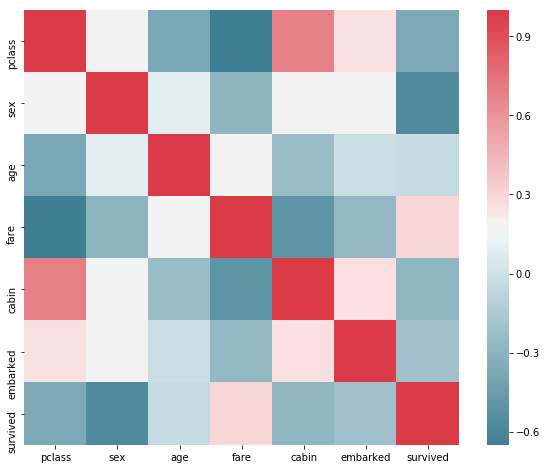

In [76]:
corr = train.corr()

f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, ax = ax)

In [77]:
# Alta correlação, 'cabin' pode ser removido
if 'cabin' in train:
    train.drop(['cabin'], axis = 1, inplace = True)

if 'cabin' in test:
    test.drop(['cabin'], axis = 1, inplace = True)
    
display(test[0:10])
display(train[0:10])

,pclass,sex,age,fare,embarked,survived
0,1.0,1.0,0.302491,0.038061,1.0,0.0
1,1.0,1.0,0.402135,0.036761,1.0,0.0
2,1.0,0.0,0.217082,0.221749,1.0,0.0
3,1.0,1.0,0.160142,0.053152,0.0,1.0
4,1.0,1.0,0.188612,0.043617,1.0,1.0
5,0.5,0.0,0.387900,0.122931,1.0,1.0
6,1.0,1.0,0.316726,0.036860,1.0,1.0
7,0.0,1.0,0.985765,0.335697,1.0,0.0
8,0.0,0.0,0.672598,0.374468,0.0,1.0
9,0.5,1.0,0.729537,0.063830,1.0,0.0


,pclass,sex,age,fare,embarked,survived
0,1.0,0.0,0.149901,0.189699,1.0,0.0
1,1.0,1.0,0.589119,0.046401,1.0,0.0
2,1.0,1.0,0.277416,0.059720,1.0,0.0
3,1.0,1.0,0.390762,0.047892,1.0,0.0
4,0.0,0.0,0.560782,0.930828,1.0,1.0
5,0.0,0.0,0.688297,0.465401,0.0,1.0
6,0.0,1.0,0.659960,0.233522,1.0,0.0
7,1.0,0.0,0.291584,0.046401,1.0,1.0
8,0.5,0.0,0.319921,0.083654,0.0,1.0
9,0.0,0.0,0.263247,0.552441,0.0,1.0


##### Construindo conjuntos de treino e teste

In [78]:
x_train = train.filter(['pclass', 'sex', 'age', 'fare', 'embarked'], axis = 1)
y_train = train.filter(['survived'], axis = 1)

x_test = test.filter(['pclass', 'sex', 'age', 'fare', 'embarked'], axis = 1)
y_test = test.filter(['survived'], axis = 1)

x_train_list = x_train.values.tolist()

y_train_list = []
for i in y_train.values.tolist():
    if(i[0] >= 0.5):
        y_train_list.append([1.0, 0.0])
    else:
        y_train_list.append([0.0, 1.0])
        
x_test_list = x_test.values.tolist()

y_test_list = []
for i in y_test.values.tolist():
    if(i[0] >= 0.5):
        y_test_list.append([1.0, 0.0])
    else:
        y_test_list.append([0.0, 1.0])

dataset = DataSet() 
for inst_x, inst_y in zip(x_train_list, y_train_list):
    dataset.add(Instance(inst_x, inst_y))
train_final_size = dataset.size() 
    
for inst_x, inst_y in zip(x_test_list, y_test_list):
    dataset.add(Instance(inst_x, inst_y))
test_final_size = dataset.size() - train_final_size
total_final_size = train_final_size + test_final_size

In [79]:
print("Treino: ", train_final_size)
print("Teste: ", test_final_size)
print("Total: ", total_final_size)
tvt = [train_final_size * 0.8, train_final_size * 0.2, test_final_size]

Treino:  546
Teste:  335
Total:  881


##### Treinamento (Holdout)

In [80]:
net = NeuralNetwork(5, [30, 10, 2], [relu_func, relu_func, soft_max_func], dropout = [0.2, 0.5, 0.5])
data = net.fit(dataset, "mini-batch", 500, lr_ = 0.001, type = "class", mini_batch_size = 20, 
                      tvt_ratio = tvt, print_info = False, opt = 'adam')

336/336 [==============================] - 0s 93us/step
[0.16479812726555837, 0.7886904776096344]


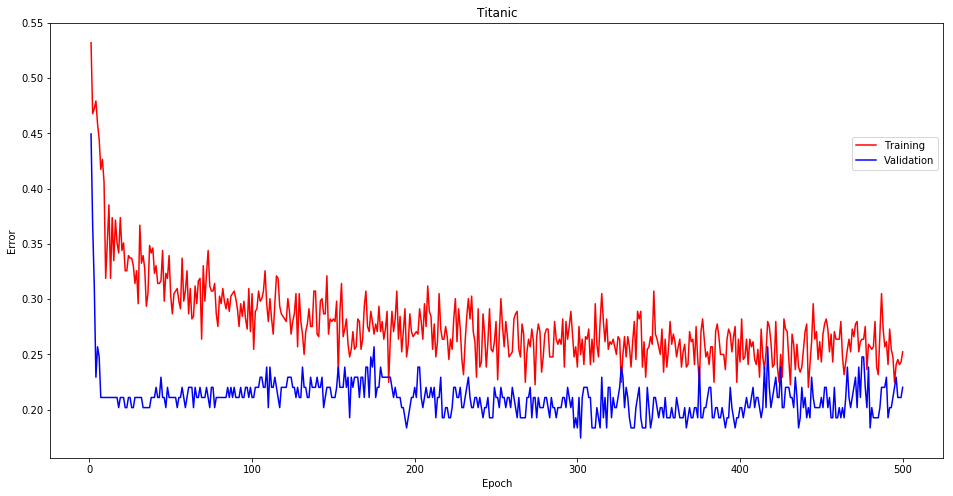

In [81]:
plot_graph(data, "Titanic", "Epoch", "Error", figsizex = 16, figsizey = 8)

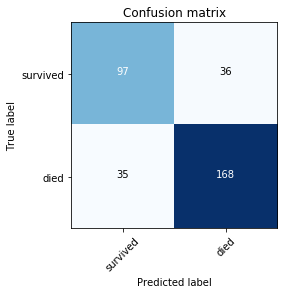

Test Accuracy:  78.86904761904762 %
Test Accuracy:  78.86904761904762 %


In [89]:
correct = []
predict = []
for i in range(len(net.confusion_matrix)):
    for j in range(len(net.confusion_matrix)):
        correct = correct + net.confusion_matrix[i][j] * [i]
        predict = predict + net.confusion_matrix[i][j] * [j]
            
mat = confusion_matrix(correct, predict)
plot_confusion_matrix(mat, classes = ['survived', 'died'], title = 'Confusion matrix')
plt.show()

correct_count = 0
total_count = 0
for i in range(len(net.confusion_matrix)):
    for j in range(len(net.confusion_matrix)):
        total_count += net.confusion_matrix[i][j]
        if(i == j):
            correct_count += net.confusion_matrix[i][j]

print('Test Accuracy: ', correct_count/total_count * 100, '%')

##### Treinamento (Cross-validation)

In [85]:
n_split = 10
kfold = StratifiedKFold(n_splits = n_split, shuffle = True, random_state = 11403723)

idx = 1
data_cv_mean = [0, 0, 0]
matrix_mean = []
for a, b in kfold.split(x_train, y_train):
    
    print("\rTraining fold: ", idx)
    idx += 1
    dataset = None
    dataset = DataSet()
    
    for ind in a:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))
    
    for ind in b:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))
        
    for ind in range(len(x_test_list)):
        dataset.add(Instance(x_test_list[ind], y_test_list[ind]))
        
    tvt = [len(a), len(b), len(x_test_list)]

    net_cv = NeuralNetwork(5, [30, 10, 2], [relu_func, relu_func, soft_max_func], dropout = [0.2, 0.5, 0.5])
    data_cv = net_cv.fit(dataset, "mini-batch", 500, lr_ = 0.001, type = "class", mini_batch_size = 20, 
                         tvt_ratio = tvt, print_info = False, opt = 'adam')
    
    if data_cv_mean[0] == 0:
        data_cv_mean = data_cv.copy()
        matrix_mean = net_cv.confusion_matrix.copy()
    else:
        data_cv_mean[1] = [ i+j for i, j in zip(data_cv_mean[1], data_cv[1]) ]
        data_cv_mean[2] = [ i+j for i, j in zip(data_cv_mean[2], data_cv[2]) ]
        
        for i in range(len(matrix_mean)):
            for j in range(len(matrix_mean[i])):
                matrix_mean[i][j] += net_cv.confusion_matrix[i][j]
                

data_cv_mean[1] = [ elem/n_split for elem in data_cv_mean[1]]
data_cv_mean[2] = [ elem/n_split for elem in data_cv_mean[2]]
matrix_mean = [ [ kk//n_split for kk in k ] for k in matrix_mean ]

n = NeuralNetwork(1, [2], [sig_func])
n.confusion_matrix = matrix_mean

Training fold:  1
335/335 [==============================] - 0s 140us/step
[0.16027437784333728, 0.776119408322804]
Training fold:  2
335/335 [==============================] - 0s 93us/step
[0.16036063388212404, 0.7880597025600832]
Training fold:  3
335/335 [==============================] - 0s 79us/step
[0.16102544140459887, 0.7910447778986461]
Training fold:  4
335/335 [==============================] - 0s 97us/step
[0.16085817131088742, 0.7820895554414437]
Training fold:  5
335/335 [==============================] - 0s 105us/step
[0.16675550857586646, 0.7850746281111418]
Training fold:  6
335/335 [==============================] - 0s 102us/step
[0.156372169282899, 0.7910447859052402]
Training fold:  7
335/335 [==============================] - 0s 111us/step
[0.15399101977028065, 0.794029853237209]
Training fold:  8
335/335 [==============================] - 0s 146us/step
[0.16927936828848142, 0.7791044872198531]
Training fold:  9
335/335 [==============================] - 0s 99us/st

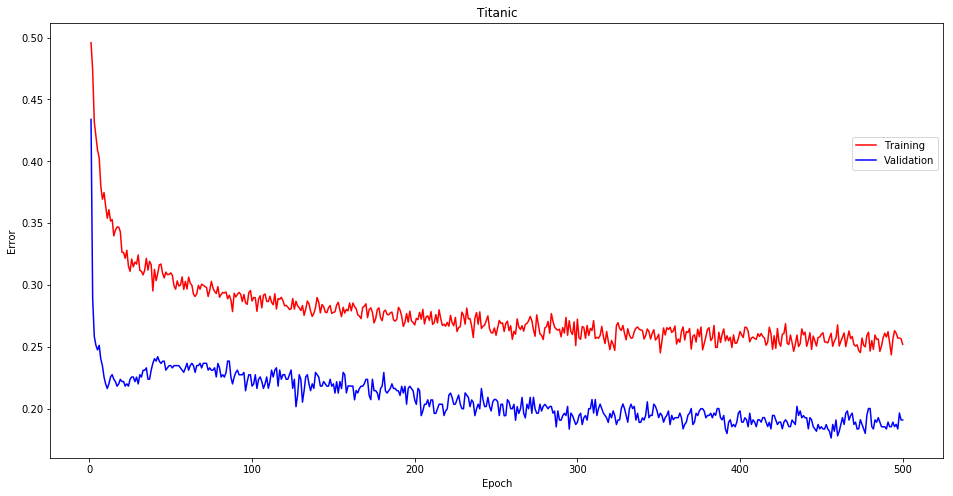

In [86]:
plot_graph(data_cv_mean, "Titanic", "Epoch", "Error", figsizex = 16, figsizey = 8)

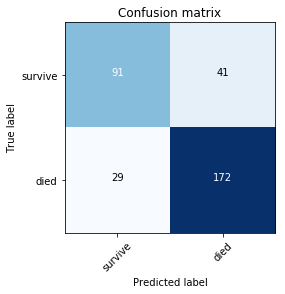

Test Accuracy:  78.86904761904762 %


In [90]:
correct = []
predict = []
for i in range(len(n.confusion_matrix)):
    for j in range(len(n.confusion_matrix)):
        correct = correct + n.confusion_matrix[i][j] * [i]
        predict = predict + n.confusion_matrix[i][j] * [j]
            
mat = confusion_matrix(correct, predict)
plot_confusion_matrix(mat, classes = ['survive', 'died'], title = 'Confusion matrix')
plt.show()

correct_count = 0
total_count = 0
for i in range(len(net.confusion_matrix)):
    for j in range(len(net.confusion_matrix)):
        total_count += net.confusion_matrix[i][j]
        if(i == j):
            correct_count += net.confusion_matrix[i][j]

print('Test Accuracy: ', correct_count/total_count * 100, '%')